# Task 2

Task 2: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.

The following technical/tool constraint applies: you are NOT allowed to use Neural Networks or other Machine Learning models. You must use Python and Jupyter Notebook.

In general, you may want to consider performing the following steps:
- Find an interesting problem which you want to solve either using **Linear Regression or Classification** (please check with your instructors first on whether the problem makes sense).
- Find a **dataset** to build your model. For example, you can use Kaggle (https://www.kaggle.com/datasets) to find suitable datasets.
- Use **plots** to visualize and understand your data.
- Create **training and test** data sets.
- Build your model.
- Choose an **appropriate metric** to evaluate your model (you may use the same metric as the one used in Task 1).
- Improve your model.

# Design task 
## Question: How did COVID-19 impact the economy?

Since macro economy indicators is usually published only once during each financial quarter, there will only be 4 data points if we look at the 2021/2021 period. Hence, we did not use macro economy indicators as the target as there is insfficient data for the time period we are looking at.

Thus, we decided to use price of gold ETFs ([SPDR Gold Shares (GLD)](https://finance.yahoo.com/quote/GLD/history?p=GLD)) as a proxy of economic health. This is because [gold usually rises alongside investors' uncertainty in the economy](https://www.npr.org/sections/coronavirus-live-updates/2020/07/27/895975866/economic-uncertainty-drives-gold-price-to-a-record-high). In uncertain economic times, investors tend to put their money in gold.

On the yahoo finance, they provide open, high, low, close, and volume of price of gold ETF. We chose to focus on close gold price because [it is a stock’s closing price that determines how a share performed during the day](https://analyzingalpha.com/open-high-low-close-stocks). 

### Goal: predict close gold prices given COVID's impact


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data 
We use data from [SPDR Gold Shares (GLD)](https://finance.yahoo.com/quote/GLD/history?period1=1479859200&period2=1637625600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) 

In [19]:
df_gold_all = pd.read_csv('GLD.csv')
df = pd.read_csv('covid_data.csv')

# display(df_gold_all)
# display(df)


## Clean data

In [20]:
# Clean covid data by selecting only the relevant columns

df_subset = df.loc[((df['location']=='United States')| (df['location']=='China') | (df['location']=='Japan') | (df['location']=='Hong Kong') | (df['location']=='United Kingdom') | 
(df['location']=='Canada') | (df['location']=='India') | (df['location']=='Saudi Arabia') | (df['location']=='France') | (df['location']=='Germany') | 
(df['location']=='South Korea') | (df['location']=='Switzerland') | (df['location']=='Australia') | (df['location']=='Netherlands') |  
(df['location']=='Iran')| (df['location']=='Sweden')| (df['location']=='Brazil')| (df['location']=='Spain')|(df['location']=='Russia') |(df['location']=='Singapore')) ,:]


In [21]:
# Fill any NaN values
df_covid=df_subset.fillna(0)
# display(df_covid.index)

In [22]:
# Change the 'date' column to DateTime object
df_covid['Week']=pd.to_datetime(df_covid['date'])

# Group by week and then take the mean for the week
df_covid=df_covid.groupby(pd.Grouper(key='Week', freq="W-MON")).mean()

# Exclude the last week to match up with gold data
df_covid=df_covid.iloc[:95,:]
# display(df_covid)


In [23]:
# Clean Up of Gold Data frame
# change to standard date 

df_gold_all = pd.read_csv('GLD.csv')

# Change gold date range to same range as covid date range
df_gold=df_gold_all.copy()
df_gold=df_gold.loc[((df_gold['Date']> '2020-01-26') & (df_gold['Date']< '2021-11-17')) ,:]

# Change the date column to DateTime Index
df_gold['Date'] = pd.to_datetime(df_gold['Date']).dt.date

In [24]:
# Sync up the indexing for both df_gold and df_covid
df_covid=df_covid.reset_index()
df_gold=df_gold.reset_index()

# Merge into one data frame
frames=[df_gold,df_covid]
df_all = pd.concat(frames,axis=1)
# display(df_all)

# Remove duplicated/unecessary columns
df_all.drop(['index','Week'], axis=1, inplace=True)
# display(df_all)

In [25]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

df_num_norm = normalize_z(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
result = pd.concat(frames,axis=1)
df_covid=result.fillna(0)
# display(df_covid.index)

In [26]:
# Clean covid data by selecting only the relevant columns
columns=['Date','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cov_gold = df_all.loc[:,columns]
df_cov_gold=df_cov_gold.fillna(0)
# display(df_cov_gold)

In [27]:
# display(df_cov_gold)
# df_cov_gold.isna().sum()

## Visualising data

In [28]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

df_num_norm = normalize_z(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
df_visual = pd.concat(frames,axis=1)
df_visual=df_visual.fillna(0)


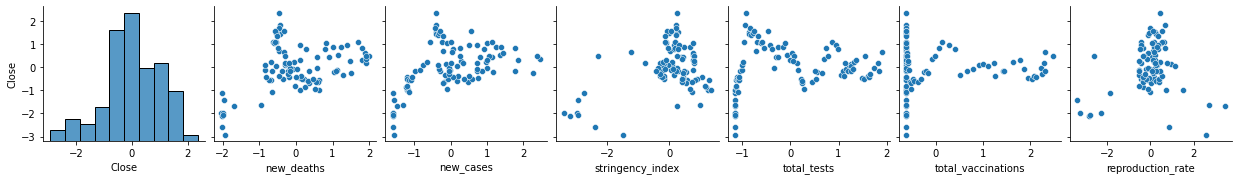

In [29]:
myplot = sns.pairplot(data=df_visual, x_vars=['Close','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate'],y_vars=['Close'])

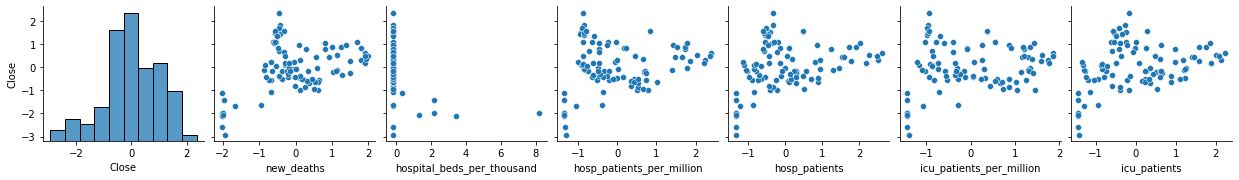

In [30]:
myplot = sns.pairplot(data=df_visual, x_vars=['Close','new_deaths','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients'],y_vars=['Close'])

Analysis of pairplots: Observe that there exists highly non-linear relationship between ```close``` and ```hosp_patients_per_million```, ```hosp_patients```,```icu_patients_per_million```,```icu_patients```. This will be important for determining which features to add polynormial terms to.

## 1. Train naive model (normal multi linear regression with 11 variables)

In [31]:
# Prepare all functions

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

def normalize_z(df):
    dfout=(df-df.mean(axis=0))/df.std(axis=0)
    return dfout

def get_features_targets(df, feature_names, target_names):
    df_feature=df.loc[:,feature_names]
    df_target=df.loc[:,target_names]
    return df_feature, df_target
    
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indices=df_target.index

    if random_state!=None:
        np.random.seed(random_state)
    
    num_rows=len(indices)
    k = int(test_size * num_rows)
    test_indices=np.random.choice(indices,k,replace=False)

    indices=set(indices)
    test_indices=set(test_indices)
    train_indices=indices-test_indices
    
    df_feature_train=df_feature.loc[train_indices,:]
    df_feature_test=df_feature.loc[test_indices,:]
    df_target_train=df_target.loc[train_indices,:]
    df_target_test=df_target.loc[test_indices,:]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def compute_cost(X, y, beta):
    J = 0
    #calculate m, no of rows/data pt
    m = X.shape[0]
    
    #calculate yp, predicted target value from X and beta
    yp = np.matmul(X, beta)
    
    #calculate the error
    error = yp-y
    
    #calculate the cost
    J = (1/(2*m))*np.matmul(error.T, error)
    J= J[0][0] #to get the float
    return J

def prepare_feature(df_feature):
    #numpy is just arrays
    feature = df_feature.to_numpy()
    array1 = np.ones((feature.shape[0],1))
    X = np.concatenate((array1, feature), axis = 1)
    return X

def prepare_target(df_target):
    return df_target.to_numpy() 

def gradient_descent(X, y, beta, alpha, num_iters):
    #calculate m from shape of X or y
    m = X.shape[0]
    J_storage = np.zeros(num_iters)

    #for the number of iterations
    for n in range(num_iters):
        #--> compute the predicted y
        yp = np.matmul(X, beta)
        
        #--> compute the error
        error = yp - y
        
        #--> compute the new beta
        beta = beta - (alpha/m)*np.matmul(X.T, error)
        
        #--> compute J using the new beta and store it
        J_storage[n] = compute_cost(X, y, beta)
        
    return beta, J_storage

def predict_norm(X, beta):
    y = np.matmul(X, beta)
    return y

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    X = prepare_feature(df_feature)
    yp = predict_norm(X, beta)
    return yp

def mean_squared_error(target, pred):
    n=target.shape[0]
    error=target-pred
    mse=(1/n)*np.sum(error**2)
    return mse

def r2_score(y, ypred):
    # calculate ssres
    diff = y - ypred
    ssres = np.matmul(diff.T, diff)[0][0]
    
    # calculate sstot
    ymean=np.mean(y)
    diff_mean=y-ymean #element wise subtraction
    sstot= np.matmul(diff_mean.T, diff_mean)[0][0]
    
    # calcuate r2
    return 1-(ssres/sstot)

def adj_r2_score(X,y,ypred):
    r2=r2_score(y, ypred)
    adj_r2=1 - ((1-r2)*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))
    return adj_r2

In [32]:
# Get features and targets from data frame

features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']

df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])

# Split into training and test data set
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# Normalize train features
df_features_train_z=normalize_z(df_features_train)

# Export same set of data to excel for excel analysis 
# frames1=[df_features_train_z, df_target_train]
# display(df_features_train_z)
# display(df_target_train)
# excel1 = pd.concat(frames1,axis=1)
# excel1 = excel1.fillna(0)
# display(excel1)
# excel1.to_excel("cov_gold_excel.xlsx")

# Prepare X and target vector
X = prepare_feature(df_features_train_z)
m=X.shape[1]
target = prepare_target(df_target_train)

# Set up gradient descent
iterations = 1500
alpha = 0.01
beta = np.zeros((m,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
print('beta:',beta)
# Normal equation
X_sq=np.linalg.inv(np.matmul(X.T,X))
Xy=np.matmul(X.T,target)
beta_n= np.matmul(X_sq,Xy)

pred = predict(df_features_test, beta)
df_features_test_z=normalize_z(df_features_test)
X_test=prepare_feature(df_features_test_z)
print('x:', X_test[1,:])
print('y pred',pred[1])




beta: [[167.59532555]
 [  3.27480948]
 [  6.15421778]
 [  3.88627622]
 [ -1.50507384]
 [ -0.83803454]
 [ -1.93104515]
 [ -1.48844009]
 [ -2.25722964]
 [  2.92575393]
 [ -9.09312879]
 [  2.24138987]]
x: [ 1.         -2.03896382 -1.60247918 -2.63718388 -0.93670598 -0.56285903
 -2.2339289   0.89869153 -1.19267259 -1.36709684 -1.16934371 -1.41238795]
y pred [151.82458058]


Text(0, 0.5, 'Iteration')

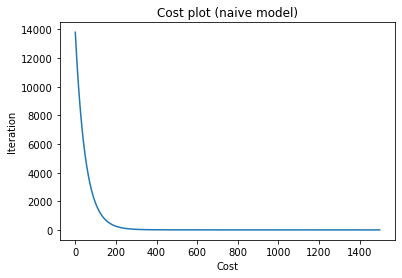

In [33]:
plt.plot(J_storage)
plt.title('Cost plot (naive model)')
plt.xlabel('Cost')
plt.ylabel('Iteration')  

Analysis of cost plot: Gradient decsent worked as expected. Converged as number of iterations increased.

In [34]:
# Call the predict method to get the predicted values
pred = predict(df_features_test, beta)
print(pred[1])
# with np.printoptions(threshold=np.inf):
#     print(beta)

[151.82458058]


## Evaluate model

### Residual plot

Text(0, 0.5, 'Residual')

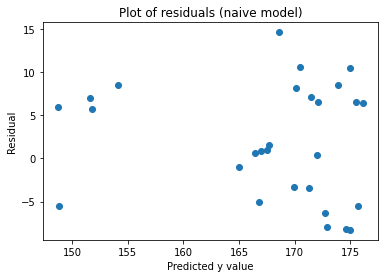

In [35]:
# Residual plot
# Calculate and plot residuals
actual=prepare_target(df_target_test)
error=actual-pred
plt.scatter(pred,error)
plt.title('Plot of residuals (naive model)')
plt.xlabel('Predicted y value')
plt.ylabel('Residual')  


Analysis for residual plots: there does not seem to be much of a discernable pattern in the residual plot. Evaluation of model fit to data cannot be seen in the residual plots.

### Line fit plot 
Check the overall fit of model to each parameter visually

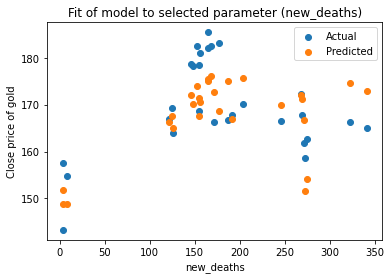

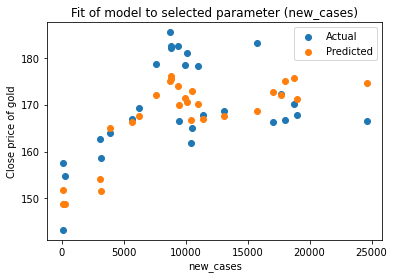

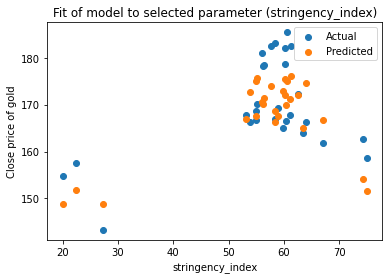

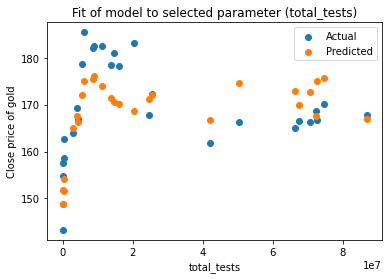

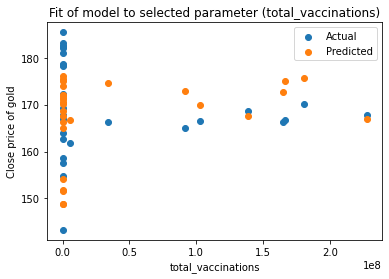

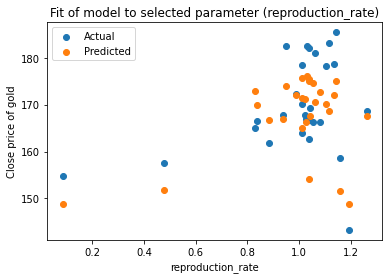

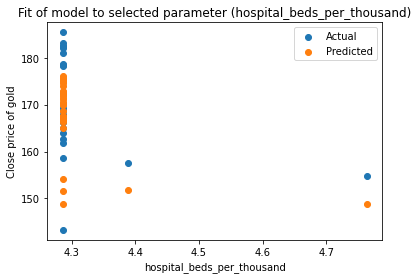

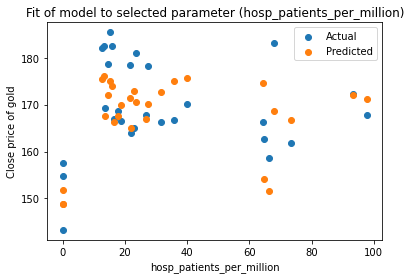

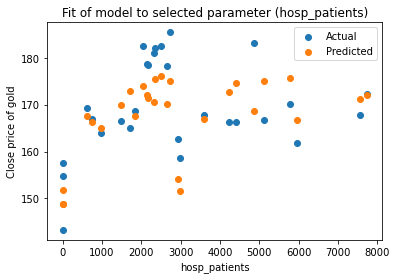

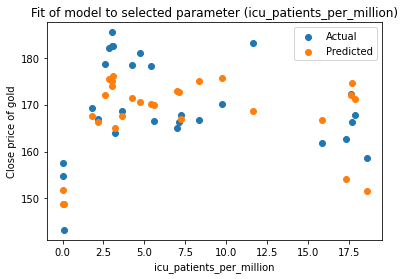

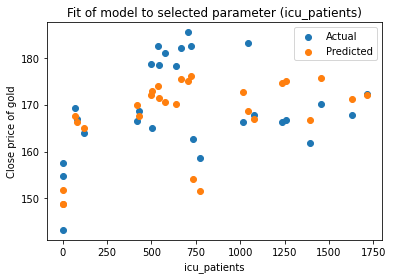

In [36]:
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']
target = prepare_target(df_target_test)
for i in range(len(features)):
    ft=features[i]
    plt.figure(i)
    plt.scatter(df_features_test[ft],target)
    plt.scatter(df_features_test[ft],pred)
    plt.legend(['Actual','Predicted'])
    plt.xlabel(ft)
    plt.ylabel('Close price of gold')
    plt.title('Fit of model to selected parameter ('+str(ft)+')')

Analysis for line fit plots: The model fit is not terrible but not the best. However, the fit of the model to the data cannot be clearly discerned from the the plots thus we much rely on the quantitative metrics of accuracy.

### Quantitative measurements of accuracy

In [20]:
mse=mean_squared_error(target,pred)
print('MSE: ',mse)

rse=np.sqrt(mse/(X.shape[0]-m-1))
print('RSE: ',rse)

r2=r2_score(target, pred)
print('r2: ',r2)

adj_r2=adj_r2_score(df_features_test,target,pred)
print('adjusted r2: ',adj_r2)

MSE:  46.31647356235523
RSE:  0.9261276766067131
r2:  0.5190818196831619
adjusted r2:  0.18845057071533577


## Further analysis into model
## 1. Excel experimentation

Did some experimentation in excel to find out:
> 1. Is there a relationship between the features and target? 

p-value of the F statistic is less than 0.05 so have  strong evidence that at least one of the factors is associated with increased gold price.

> 2. How strong is the relationship? (p-value of the t statistic)

Note: we did not split into training and testing for excel experimentation. It was just a quick experiment to check for the above two questions whcih are not very affected by the splitting of data. Other evaluation metrics such as standard error, r2 and adjusted r2 heavily affected by the lack of splitting data and thus will not be used to draw any conclusions from.

### P-values of t-Stat in excel
<img src="./images/excel_task 2_naive.png">

This suggests that
- total_tests
- total_vaccinations
- reproduction_rate
- hospital_beds_per_thousand
as their individual p-value of the t statistic>0.05. This suggests that these variables have no relation to the output variable of gold close price. Thus, we will remove them before building the next model.

## 2. Feature selection simulation
### Can we confirm with another method that is not excel that addition of these variables contribute noise and give us a worse model? 
Yes, we created a simulation to find a combination of features that minimises the mse and maximises r2.

In [21]:
import itertools

def evalue_models_with_diff_feature_combinations(features):
    #1 get all different combinations of features
    store_evaluations = []
    for L in range(0, len(features)+1):
        #2 for each combination, run model, print combination, r2 and adj_r2
        for features_subset in itertools.combinations(features, L):
            features_list = [*features_subset]
            if features_list == []:
                continue
            #run base model

            # Get features and targets from data frame
            df_feature, df_target = get_features_targets(df_cov_gold, features_list, ['Close'])

            # Split into training and test data set
            df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

            # Normalize train features
            df_features_train_z=normalize_z(df_features_train)
            
            # Prepare X and target vector
            X = prepare_feature( df_features_train_z)
            m=X.shape[1]
            target = prepare_target(df_target_train)

            # Set up gradient descent
            iterations = 1500
            alpha = 0.01
            beta = np.zeros((m,1))

            # Call the gradient_descent function
            beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

            # Call the predict method to get the predicted values
            target = prepare_target(df_target_test)
            pred = predict(df_features_test, beta)

            # Evaluate model
            mse=mean_squared_error(target,pred)
            #print('MSE: ',mse)

            rse=np.sqrt(mse/(X.shape[0]-m-1))
            #print('RSE: ',rse)

            r2=r2_score(target, pred)
            #print('r2: ',r2)

            adj_r2=adj_r2_score(df_features_test,target,pred)
            #print('adjusted r2: ',adj_r2)
            
            #print('―' * 10)
            #print(f"feature combination: {features_subset}")
            #print(f"mse {mse}")
            #print("r2_1",r2)
            #print("adj_r2_1",adj_r2)
            #print('―' * 10)
            
            store_evaluations.append([features_subset,mse,r2,adj_r2])
    #print max 
    #print('―' * 10)
    #print('―' * 10)
    #print('―' * 10)
    
    best_fit = max(store_evaluations, key=lambda x: x[3])
    print(f"best_fit combination:", best_fit[0])
    print(f"best_fit mse:", best_fit[1])
    print(f"best_fit r2:", best_fit[2])
    print(f"best_fit adj_r2:", best_fit[3])
    return None    

In [22]:
features=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients']

# evalue_models_with_diff_feature_combinations(features)

### Result of the simulation:
<img src="./images/best_fit.png">
Simulated results corroborate with what we learn from excel

## Insights
Next step is to 
1. remove variables that have no relation to our target 
- total_vaccinations
- reproduction_rate
- hospital_beds_per_thousand

2. Add polynomial terms to model
- new_cases
- hosp_patients_per_million
- hosp_patients
- icu_patients_per_million
- icu_patients

# 2. Naive polynomial regression model

In [23]:
# Function for creating higher order terms
def transform_features(df_feature, colname, colname_transformed,power):
    df_out=df_feature.copy()
    if power==1:
        return df_out
    for i in range(1,power):
        df_out.loc[:,colname_transformed+str(i)]=df_feature[colname]**i 
    return df_out

In [24]:
# display(df_covid)

In [32]:
# Run polynomial regression for various powers to see which model has the best fit to data

features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million', 'icu_patients'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'icu_patients', 'new_cases']

all={}
mse_all=[]
r2_all=[]
adj_r2_all=[]
for i in range(1,8):
    print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split into training and test data set
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
    
    # Normalize train features
    df_features_train_z=normalize_z(df_features_train)

    # Prepare X and target vector
    X = prepare_feature(df_features_train_z)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    # Set up gradient descent
    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    all[i]=pred

    # Collect evaluation metric

    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    # print("MSE: ",mse2)
    mse_all.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    # print("r2: ",r2)
    r2_all.append(r2)

    #adj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    # print('adjusted r2: ',adj_r2)
    adj_r2_all.append(adj_r2)
    # print("_" * 10)
    
    

Power: 1
Power: 2
Power: 3
Power: 4
Power: 5
Power: 6
Power: 7


## Evaluate model
### Quantitative measurements of accuracy

Text(0.5, 1.0, 'Plot of adjusted r2 against maximum power of features')

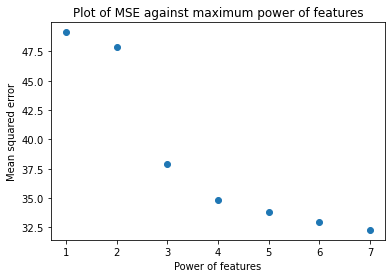

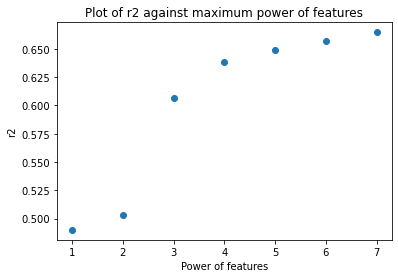

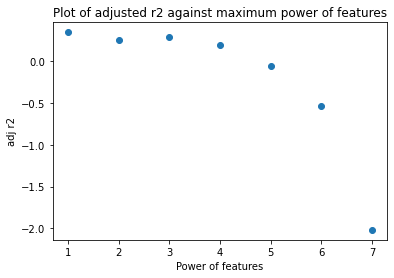

In [34]:
power=list(range(1,8))
plt.figure(6)
plt.scatter(power,mse_all)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')
plt.title('Plot of MSE against maximum power of features')

plt.figure(7)
plt.scatter(power,r2_all)
plt.xlabel('Power of features')
plt.ylabel('r2')
plt.title('Plot of r2 against maximum power of features')

plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.xlabel('Power of features')
plt.ylabel('adj r2')
plt.title('Plot of adjusted r2 against maximum power of features')

Analysis of MSE,r2, adjusted r2 plots: Raising the selected features to power 3 minimises the MSE and maximises the adjusted r2. 

## Further analysis
### Checking for collinearity

> Collinearity refers to the situation in which two or more predictor variables are closely related to one another.

Text(0.5, 1.0, 'Collinearity plot for number of icu patients')

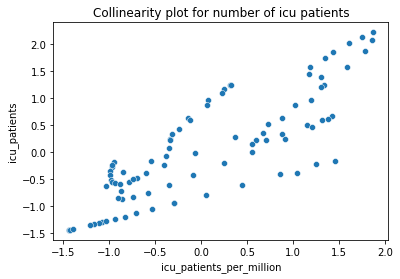

In [35]:
myplot = sns.scatterplot(x='icu_patients_per_million', y='icu_patients', data=df_covid)
myplot.set_title('Collinearity plot for number of icu patients', fontsize=12)

Text(0.5, 1.0, 'Collinearity plot for number of patients hospitalised')

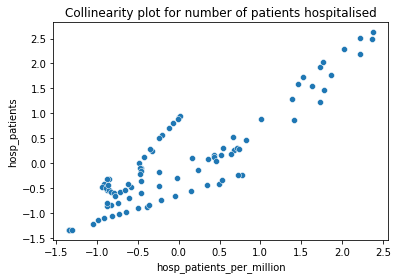

In [36]:
myplot = sns.scatterplot(x='hosp_patients_per_million', y='hosp_patients', data=df_covid)
myplot.set_title('Collinearity plot for number of patients hospitalised', fontsize=12)

Analysis of the plots: ```hosp_patients_per_million```and ```hosp_patients``` (similarly for ```icu_patients_per_million``` and ```icu_patients```) are highly collinear. This could cause inaccurate estimates of the regression coefficients.

It can also cause inflated the standard errors of the regression coefficients, deflate the partial t-tests for the regression coefficients, give false, nonsignificant, pvalues, and degrade the predictability of the model. 

## Insights
``'icu_patients'`` and ``'icu_patients_per_million'`` (similarly for ``'hosp_patients_per_million'`` and ``'hosp_patients'``) are quite collinear based on the plots. 
<img src="./images/excel_task 2_naive.png">

As p-value of t-statistic for ```'icu_patients_per_million'``` is smaller than that of ``'icu_patients'``, we decided to discard ``'icu_patients'`` in our next model and keep ```'icu_patients_per_million'```. 

### 3. Updated polynomial model that removes collinear terms

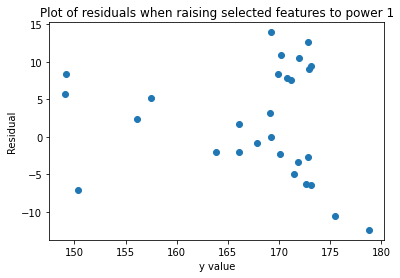

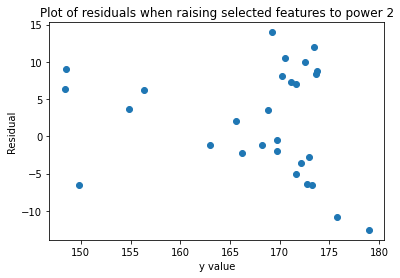

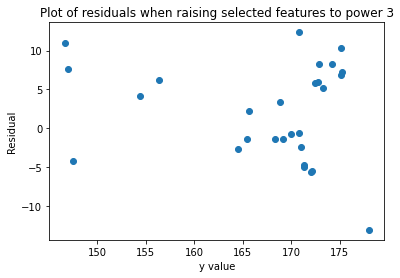

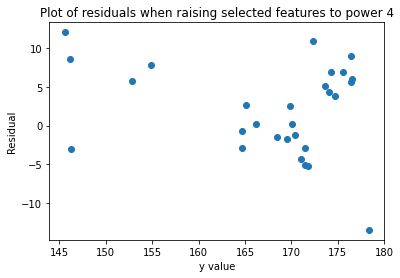

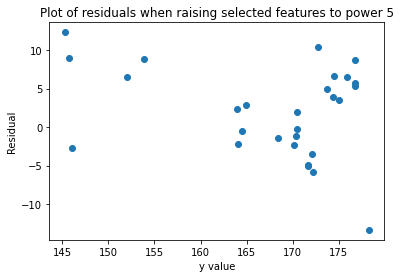

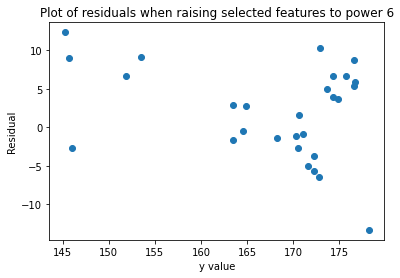

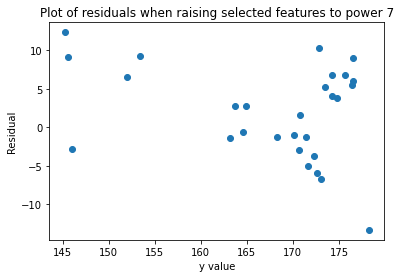

In [37]:
features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'new_cases']

mse_all_1=[]
r2_all_1=[]
adj_r2_all_1=[]
error_all_1=[]
for i in range(1,8):
    # print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split into training and test data set
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
    
    # Normalize train features
    df_features_train_z=normalize_z(df_features_train)

    # Prepare X and target vector
    X = prepare_feature(df_features_train_z)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    # Set up gradient descent
    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    all[i]=pred

    # Collect evaluation metric

    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    # print("MSE: ",mse2)
    mse_all_1.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    # print("r2: ",r2)
    r2_all_1.append(r2)

    #adj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    # print('adjusted r2: ',adj_r2)
    adj_r2_all_1.append(adj_r2)

    # Residual plot
    # Calculate and plot residuals
    plt.figure(i)
    error=actual-pred
    error_all_1.append(error)
    # print(error)
    plt.scatter(pred,error)
    plt.title('Plot of residuals when raising selected features to power '+str(i))
    plt.xlabel('y value')
    plt.ylabel('Residual')  

    # print("_" * 10)
    

Analysis for residual plots: there does not seem to be much of a discernable pattern in the residual plot for all powers. Increasing the power of selected features does not randomise the plot further either. Improvement of model fit to data by raising selected features to higher power cannot be seen in the residual plots.

## Evaluate model

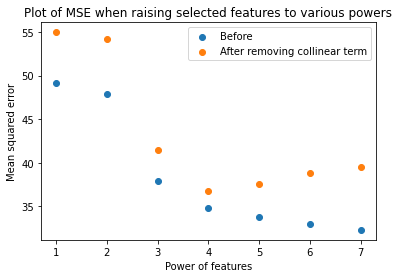

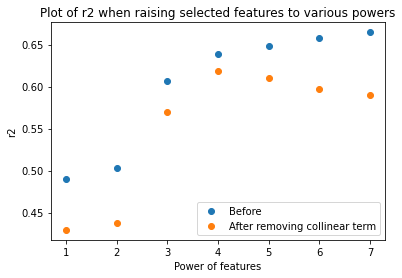

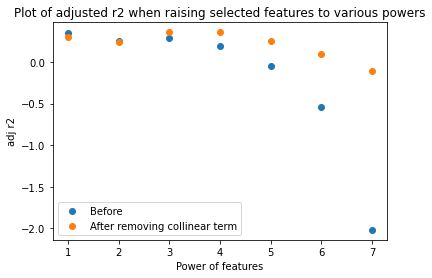

In [38]:
power=list(range(1,8))
plt.figure(6)
plt.scatter(power,mse_all)
plt.scatter(power,mse_all_1)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')
plt.title('Plot of MSE when raising selected features to various powers')
plt.legend(['Before', 'After removing collinear term'])

plt.figure(7)
plt.scatter(power,r2_all)
plt.scatter(power,r2_all_1)
plt.xlabel('Power of features')
plt.ylabel('r2')
plt.title('Plot of r2 when raising selected features to various powers')
plt.legend(['Before', 'After removing collinear term'])

plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.scatter(power,adj_r2_all_1)
plt.xlabel('Power of features')
plt.ylabel('adj r2')
plt.title('Plot of adjusted r2 when raising selected features to various powers')
plt.legend(['Before', 'After removing collinear term'])

Analysis of MSE,r2, adjusted r2 plots: Raising the selected features to power 4 minimises the MSE and maximises the adjusted r2. Creating a model with selcted features raised to the power of 4 produces the model with best fit to the data

## Insights
Removing collinear term helped. How model fit is still quite low as adjusted r2 is below 0.5. Maybe there is multicollineaity at play between the variables that is not easily detected. Possible to implement ridge regression to reduce the negative effects from multicollinearity between the variables.

> Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where independent variables are highly correlated. It is a model tuning method that is used to analyse any data that suffers from multicollinearity. This method performs L2 regularization. When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values to be far away from the actual values. - [Great Learning](https://www.mygreatlearning.com/blog/what-is-ridge-regression/)

## 4. Polynomial model implemented with ridge regression (L2 regularisation)
We tried to write our own ridge regression function. But it does not work as expected and we did not have time to debug further. Thus, we used the one from sklearn. Our self written ridge regression can be found in the appendix.

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [44]:
# Using sk learn

# Run ridge regression
features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'new_cases']

mse_all_ridge_2=[]
r2_all_ridge_2=[]
adj_r2_all_ridge_2=[]
for i in range(1,8):

    # Raise to appropriate power
    print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split the data into training and test data set using scikit-learn function
    df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_feature,df_target,test_size=0.3,random_state=100)

    # Instantiate Ridge() object
    model = Ridge(0.03)

    # Call the fit() method
    model.fit(df_features_train,df_target_train)

    # Call the predict() method
    pred = model.predict(df_features_test)
    all[i]=pred

    # Collect evaluation metric
    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    print("MSE: ",mse2)
    mse_all_ridge_2.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    print("r2: ",r2)
    r2_all_ridge_2.append(r2)

    # adj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    print('adjusted r2: ',adj_r2)
    adj_r2_all_ridge_2.append(adj_r2)
    print("_" * 10)
    




Power: 1
MSE:  55.01066641623077
r2:  0.41617400851671205
adjusted r2:  0.2892553147159972
__________
Power: 2
MSE:  55.01092273879218
r2:  0.41617128817567084
adjusted r2:  0.22156171756756105
__________
Power: 3
MSE:  27.459582333356177
r2:  0.7085725564531871
adjusted r2:  0.5705279779310126
__________
Power: 4
MSE:  23.978445060921707
r2:  0.7455177263987894
adjusted r2:  0.5808527258333003
__________
Power: 5
MSE:  24.720841997547613
r2:  0.7376386975515422
adjusted r2:  0.510258902096212
__________
Power: 6
MSE:  25.578541381646133
r2:  0.7285359684639305
adjusted r2:  0.41530823976846576
__________
Power: 7
MSE:  25.92728651320825
r2:  0.724834750400716
adjusted r2:  0.2995793646563679
__________


/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.99315e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.81492e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.37662e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77179e-38): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shanghongsim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridg

## Model evaluation

Text(0.5, 1.0, 'Plot of adjusted r2 when raising selected features to various powers')

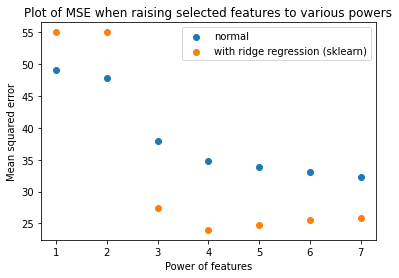

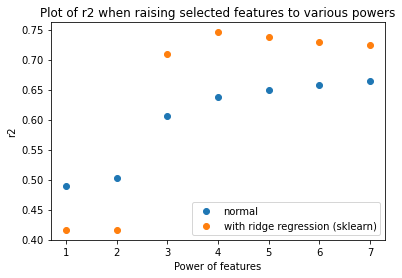

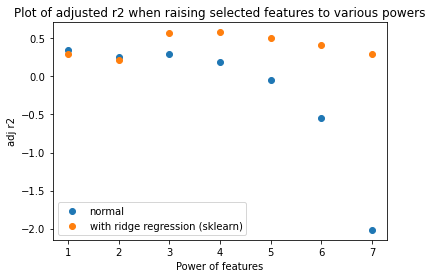

In [45]:
# plot evaluation metrics

power=list(range(1,8))
plt.figure(6)
plt.scatter(power,mse_all)
plt.scatter(power,mse_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')
plt.legend(['normal', 'with ridge regression (sklearn)'])
plt.title('Plot of MSE when raising selected features to various powers')

plt.figure(7)
plt.scatter(power,r2_all)
plt.scatter(power,r2_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('r2')
plt.legend(['normal', 'with ridge regression (sklearn)'])
plt.title('Plot of r2 when raising selected features to various powers')

plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.scatter(power,adj_r2_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('adj r2')
plt.legend(['normal', 'with ridge regression (sklearn)'])
plt.title('Plot of adjusted r2 when raising selected features to various powers')

Analysis of MSE,r2, adjusted r2 plots: Adding ridge regression significantly improve the fit of the model to data. This is to be expected as ridge regression decreases variance and increases bias, making it less prone to overfitting to training data. It generalises better to unseen data and thus is able to make better prediction than the regular polynomial regression model.

Ridge regression will also imrpove our model greatly as many of our independent features suffer from multicollinearity eg ``total_tests`` and ``icu_patients_per_million``. Ridge regression helps to minimise the negative effects arising from multicollinearity and thus will allow us to have a better resulting model. 

As seen from the graphs, the model is best when the selected features are raised to a power of 4 as MSE is minimised and adjusted r2 is maximised at this point.

# Appendix
We tried to write our own ridge regression function. But it does not work as expected and thus we used the one from sklearn.

In [ ]:
# Self written ridge regression

def compute_cost_ridge(X, y, beta,l):
    J = 0
    #calculate m, no of rows/data pt
    m = X.shape[0]
    
    #calculate yp, predicted target value from X and beta
    yp = np.matmul(X, beta)
    
    #calculate the error
    error = yp-y
    
    #calculate the cost
    penalty=l*np.matmul(beta.T,beta)
    J = (1/(2*m))*(np.matmul(error.T, error)+penalty)
    J= J[0][0] #to get the float
    return J

def gradient_descent_ridge(X, y, beta, alpha, num_iters,lam):
    #calculate m from shape of X or y
    m = X.shape[0]
    J_storage = np.zeros(num_iters)

    #for the number of iterations
    for n in range(num_iters):
        #--> compute the predicted y
        yp = np.matmul(X, beta)
        
        #--> compute the error
        error = yp - y

        #--> compute penalty
        penalty=lam*beta
        
        #--> compute the new beta
        delta = np.matmul(X.T, error)+penalty
        beta = beta - (alpha/m)*delta
        
        #--> compute J using the new beta and store it
        J_storage[n] = compute_cost_ridge(X, y, beta,lam)
        
    return beta, J_storage


def split_data_validation(df_feature, df_target, random_state=None, test_size=0.2, validation_size=0.2):
    indices=df_target.index

    if random_state!=None:
        np.random.seed(random_state)
    
    num_rows=len(indices)
    k1 = int(test_size * num_rows)
    k2 = int(validation_size * num_rows)
    test_indices=np.random.choice(indices,k1,replace=False)
    

    indices=set(indices)
    test_indices=set(test_indices)
    remaining_indices=indices-test_indices
    validation_indices=np.random.choice(list(remaining_indices),k2,replace=False)
    validation_indices=set(validation_indices)
    train_indices=indices-test_indices-validation_indices
    
    df_feature_train=df_feature.loc[train_indices,:]
    df_target_train=df_target.loc[train_indices,:]
    df_feature_validation=df_feature.loc[validation_indices,:]
    df_target_validation=df_target.loc[validation_indices,:]
    df_feature_test=df_feature.loc[test_indices,:]
    df_target_test=df_target.loc[test_indices,:]
    return df_feature_train, df_target_train, df_feature_test, df_target_test,df_feature_validation,df_target_validation

In [ ]:
# Tune hyperparameter lamda

def getRidgeLambda(random_state=100, test_size=0.2, validation_size=0.2):
    
    all={}
    lam_out=[]
    features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million', 'icu_patients'] #maybe because of collinearity
    
    for j in range(1,10):
        lam_all=[]
        mse_all=[]
        r2_all=[]
        adj_r2_all=[]

        bestMSE=10e100
        best_adjr2=0
        best_r2=0

        # Raise selected features to appropriate power
        print(f"Power: {j}")
        power_feature=['icu_patients_per_million', 'icu_patients', 'new_cases']
        df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
        for f in power_feature:
            df_feature = transform_features(df_feature, f, f+"^",j)
        
        # Various values for lamda
        lamList=[l*0.05 for l in range(0,300)]
        
        # Split data
        df_features_train, df_target_train, buf1, buf2 ,df_features_validation,df_target_validation=split_data_validation(df_feature, df_target, random_state=100, test_size=0.25, validation_size=0.25)

        for i in range(len(lamList)):
            l=lamList[i]
            
            # Normalize train features
            df_features_train_z=normalize_z(df_features_train)


            # Prepare X and target vector
            X = prepare_feature(df_features_train_z)
            m=X.shape[1]
            target = prepare_target(df_target_train)

            # Set up gradient descent
            iterations = 1500
            alpha = 0.01
            beta = np.zeros((m,1))

            # Call the gradient_descent function
            beta, J_storage=gradient_descent_ridge(X, target, beta, alpha, iterations,l)
            
            # plt.figure(i)
            # plt.plot(J_storage)

            # Get predicted y values
            pred = predict(df_features_validation, beta)

            # Evaluate model
            actual=prepare_target(df_target_validation)
            mse=mean_squared_error(actual, pred)
            r2=r2_score(actual, pred)
            adj_r2=adj_r2_score(df_features_validation,actual,pred)

            # Get best lambda
            if mse< bestMSE and r2>best_r2:
                bestMSE=mse
                best_r2=r2
                best_adjr2=adj_r2
                ridgeLambda=l

        # get best lamda for all powers and the corresponding metrics       
        lam_all.append(ridgeLambda)
        lam_out.append(ridgeLambda)
        mse_all.append(bestMSE)
        r2_all.append(best_r2)
        adj_r2_all.append(best_adjr2)
        all[j]=[lam_all,mse_all,r2_all,adj_r2_all]

    return all_values,lam_out

all_values,lam_values=getRidgeLambda()
# print(lam_values)



In [ ]:
print(lam_values)

In [ ]:
# Run ridge regression
features=['new_deaths', 'new_cases', 'stringency_index', 'total_tests', 'icu_patients_per_million', 'icu_patients'] #maybe because of collinearity
power_feature=['icu_patients_per_million', 'icu_patients', 'new_cases']

mse_all_ridge=[]
r2_all_ridge=[]
adj_r2_all_ridge=[]
for i in range(1,8):

    # Raise to appropriate power
    print(f"Power: {i}")
    df_feature, df_target = get_features_targets(df_cov_gold, features, ['Close'])
    for f in power_feature:
        df_feature = transform_features(df_feature, f, f+"^",i)

    # Split into training and test data set
    df_features_train, df_target_train, df_features_test,df_target_test,buf1,buf2=split_data_validation(df_feature, df_target, random_state=100, test_size=0.2, validation_size=0.2)
    
    # Normalize train features
    df_features_train_z=normalize_z(df_features_train)

    # Prepare X and target vector
    X = prepare_feature(df_features_train_z)
    m=X.shape[1]
    target = prepare_target(df_target_train)

    # Set up gradient descent
    iterations = 1500
    alpha = 0.01
    beta = np.zeros((m,1))
    lam=lam_values[i-1]

    # Call the gradient_descent function
    beta, J_storage = gradient_descent_ridge(X, target, beta, alpha, iterations,lam)

    # Call the predict method to get the predicted values
    pred = predict(df_features_test, beta)
    all[i]=pred

    # Collect evaluation metric
    # MSE
    actual=prepare_target(df_target_test)
    mse2=mean_squared_error(actual,pred)
    # print("MSE: ",mse2)
    mse_all_ridge.append(mse2)
    
    # r_2
    r2 = r2_score(actual,pred)
    # print("r2: ",r2)
    r2_all_ridge.append(r2)

    #madj r2
    adj_r2=adj_r2_score(df_features_test,actual,pred)
    # print('adjusted r2: ',adj_r2)
    adj_r2_all_ridge.append(adj_r2)
    # print("_" * 10)
    

In [ ]:
# plot evaluation metrics

power=list(range(1,8))
plt.figure(6)
plt.scatter(power,mse_all)
plt.scatter(power,mse_all_ridge)
plt.scatter(power,mse_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('Mean squared error')
plt.legend(['normal','with ridge regression (own)', 'with ridge regression (sk learn)'])
plt.title('Plot of MSE when raising selected features to various powers')

plt.figure(7)
plt.scatter(power,r2_all)
plt.scatter(power,r2_all_ridge)
plt.scatter(power,r2_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('r2')
plt.legend(['normal','with ridge regression (own)', 'with ridge regression (sk learn)'])
plt.title('Plot of r2 when raising selected features to various powers')

plt.figure(8)
plt.scatter(power,adj_r2_all)
plt.scatter(power,adj_r2_all_ridge)
plt.scatter(power,adj_r2_all_ridge_2)
plt.xlabel('Power of features')
plt.ylabel('adj r2')
plt.legend(['normal','with ridge regression (own)', 'with ridge regression (sk learn)'])
plt.title('Plot of adjusted r2 when raising selected features to various powers')

*Analysis of plots for metrics: L2 regularisation seems to make model much worse by increasing MSE and decreasing adjusted r2. It is better to use model the polynomial model developed with ridge regression.*